In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import prince
import gower
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

### Quality of clusters scoring methods

In [2]:
def normalize_score(score, score_min, score_max):
    """ Normalize a score to a 0-1 scale. """
    return (score - score_min) / (score_max - score_min)

In [3]:
#The silhouette score ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
def gower_silhouette_score(X, labels):
    # Compute the Gower distance matrix
    gower_dist_matrix = gower.gower_matrix(X)

    # Initialize variables to store the intra and nearest-cluster distances
    a = np.zeros(X.shape[0])
    b = np.zeros(X.shape[0])

    # Calculate the average intra-cluster distance (a) and the average nearest-cluster distance (b)
    for i in range(X.shape[0]):
        # Same cluster mask
        same_cluster_mask = (labels == labels[i])
        
        # Different cluster mask
        different_cluster_mask = ~same_cluster_mask

        # Intra-cluster distances (a)
        a[i] = np.mean(gower_dist_matrix[i][same_cluster_mask])

        # Nearest-cluster distances (b)
        b[i] = np.min([np.mean(gower_dist_matrix[i][labels == label]) 
                       for label in set(labels) if label != labels[i]])

    # Calculate the silhouette scores
    s = (b - a) / np.maximum(a, b)

    # Return the average silhouette score
    return np.mean(s)

# calculate dunn index for a clustering and gower distance matrix
# The Dunn Index measures the ratio between the smallest distance between observations not in the same cluster to the largest intra-cluster distance.
# A higher value indicates better clustering quality (i.e., clusters are compact and well-separated).
from scipy.spatial.distance import pdist, squareform
import numpy as np

def calculate_dunn_index(distance_matrix, cluster_labels):
    """
    Calculate the Dunn Index for a given clustering.
    
    :param distance_matrix: The precomputed distance matrix (2D squareform format).
    :param cluster_labels: The labels of the clusters for each point.
    :return: The Dunn Index value.
    """
    # Unique cluster labels
    unique_clusters = np.unique(cluster_labels)

    # If there's only one cluster, Dunn Index is not applicable
    if len(unique_clusters) == 1:
        raise ValueError("Dunn Index cannot be calculated for a single cluster")

    # Initialize minimum inter-cluster distance to a large value
    min_inter_cluster_dist = np.inf

    # Initialize maximum intra-cluster distance to 0
    max_intra_cluster_dist = 0

    # Calculate minimum inter-cluster distance
    for i in range(len(unique_clusters)):
        for j in range(i+1, len(unique_clusters)):
            cluster_i = unique_clusters[i]
            cluster_j = unique_clusters[j]
            inter_cluster_distances = distance_matrix[np.ix_(cluster_labels == cluster_i, cluster_labels == cluster_j)]
            min_distance = np.min(inter_cluster_distances)
            if min_distance < min_inter_cluster_dist:
                min_inter_cluster_dist = min_distance

    # Calculate maximum intra-cluster distance
    for cluster in unique_clusters:
        intra_cluster_distances = distance_matrix[np.ix_(cluster_labels == cluster, cluster_labels == cluster)]
        max_distance = np.max(intra_cluster_distances)
        if max_distance > max_intra_cluster_dist:
            max_intra_cluster_dist = max_distance

    # Calculate Dunn Index
    dunn_index = min_inter_cluster_dist / max_intra_cluster_dist

    return dunn_index


# calculate davies bouldin index for a clustering and gower distance matrix
# Lower values are preferred, indicating that clusters are farther apart and less dispersed.
def davies_bouldin_index(X, labels):
    # Compute the Gower distance matrix
    gower_dist_matrix = gower.gower_matrix(X)

    # Initialize variables to store the intra and nearest-cluster distances
    a = np.zeros(X.shape[0])
    b = np.zeros(X.shape[0])

    # Calculate the average intra-cluster distance (a) and the average nearest-cluster distance (b)
    for i in range(X.shape[0]):
        # Same cluster mask
        same_cluster_mask = (labels == labels[i])
        
        # Different cluster mask
        different_cluster_mask = ~same_cluster_mask

        # Intra-cluster distances (a)
        a[i] = np.mean(gower_dist_matrix[i][same_cluster_mask])

        # Nearest-cluster distances (b)
        b[i] = np.min([np.mean(gower_dist_matrix[i][labels == label]) 
                       for label in set(labels) if label != labels[i]])

    # Calculate the Davies-Bouldin index
    db_index = np.mean((a + b) / np.max(b))

    # Return the Davies-Bouldin index
    return db_index

In [4]:
df = pd.read_csv('./in-vehicle-coupon-recommendation.csv')

In [5]:
df = df.drop(columns=['car'])
df = df.drop(columns=['toCoupon_GEQ5min'])
df = df.drop(columns=['direction_opp'])
df = df.drop_duplicates()

In [6]:
def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df

In [7]:
df = value_mapping(df)

In [8]:
from sklearn.preprocessing import OrdinalEncoder

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Columns for ordinal encoding
ordinal_cols = ['destination', 'weather', 'time', 'expiration', 'maritalStatus', 'education']

# Define the specific ordering for ordinal columns
ordinal_ordering = {
    'destination': ['No Urgent Place', 'Home', 'Work'],
    'weather': ['Sunny', 'Rainy', 'Snowy'],
    'time': ['7AM', '10AM', '2PM', '6PM', '10PM'],
    'expiration': ['2h', '1d'],
    'maritalStatus': ['Single', 'Unmarried partner', 'Married partner', 'Divorced', 'Widowed'],
    'education': ['Some High School', 'High School Graduate', 'Some college - no degree', 
                  'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']
}

# Ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[ordinal_ordering[col] for col in ordinal_cols])
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# Identify columns to be one-hot encoded (excluding already binary or ordinal encoded columns)
columns_to_encode = df.columns.drop(ordinal_cols + ['temperature', 'age', 'has_children', 'income',
                                                    'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
                                                    'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 
                                                    'direction_same', 'Y'])  # Add any other columns to exclude

# One-hot encoding for the non-binary categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=int)

# df now contains your processed data

In [9]:
### Code for mode imputation
df_mode = df.copy()

for column in df_mode.columns:
    df_mode[column].fillna(df_mode[column].mode()[0], inplace=True)

In [10]:
columns_to_impute = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
# get columns and subtract columns to impute
columns_to_dummy = list(set(df.columns) - set(columns_to_impute))

# Pass nominal columns to dummy variables
df_clean_dummies = pd.get_dummies(df, columns=columns_to_dummy, drop_first=True)


# Columns to impute
columns_to_impute = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

# Function to impute missing values using Decision Trees
def impute_with_decision_tree(data, column_to_impute, features):
    # Split data into train and predict sets
    train_data = data[data[column_to_impute].notna()]
    predict_data = data[data[column_to_impute].isna()]
    
    # Train a decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(train_data[features], train_data[column_to_impute])
    
    # Predict missing values
    if not predict_data.empty:
        predicted_values = clf.predict(predict_data[features])
        data.loc[data[column_to_impute].isna(), column_to_impute] = predicted_values

    return data

# Features to use for imputation
features = df_clean_dummies.drop(columns=columns_to_impute).columns.tolist()

# Impute missing values for each column
for column in columns_to_impute:
    df_clean_dummies = impute_with_decision_tree(df_clean_dummies, column, features)

# Now substitute NAN values with the values imputeted in df_clean_dummies in df_clean
df['Bar'] = df_clean_dummies['Bar']
df['CoffeeHouse'] = df_clean_dummies['CoffeeHouse']
df['CarryAway'] = df_clean_dummies['CarryAway']
df['RestaurantLessThan20'] = df_clean_dummies['RestaurantLessThan20']
df['Restaurant20To50'] = df_clean_dummies['Restaurant20To50']

# Check if there are still NAN values
df.isna().sum()

destination                                             0
weather                                                 0
temperature                                             0
time                                                    0
expiration                                              0
age                                                     0
maritalStatus                                           0
has_children                                            0
education                                               0
income                                                  0
Bar                                                     0
CoffeeHouse                                             0
CarryAway                                               0
RestaurantLessThan20                                    0
Restaurant20To50                                        0
toCoupon_GEQ15min                                       0
toCoupon_GEQ25min                                       0
direction_same

In [11]:
X = df.drop("Y", axis=1)
y = df["Y"]

In [14]:
import gower

# Compute Gower distance matrix
D = gower.gower_matrix(X)

In [12]:
mca = prince.MCA(n_components=2, random_state=42)
X_mca = mca.fit_transform(X)

In [41]:
for column in X.columns:
    print(f"{column}: {X[column].unique()}")

destination: [0. 1. 2.]
weather: [0. 1. 2.]
temperature: [1 2 0]
time: [2. 1. 3. 0. 4.]
expiration: [1. 0.]
age: [1 6 2 3 5 7 4 0]
maritalStatus: [1. 0. 2. 3. 4.]
has_children: [1 0]
education: [2. 4. 3. 1. 5. 0.]
income: [3 5 1 6 4 2 8 7 0]
Bar: [0 1 2 4 3]
CoffeeHouse: [0 1 3 2 4]
CarryAway: [2 3 4 1 0]
RestaurantLessThan20: [3 2 1 4 0]
Restaurant20To50: [2 1 0 4 3]
toCoupon_GEQ15min: [0 1]
toCoupon_GEQ25min: [0 1]
direction_same: [0 1]
passanger_Alone: [1 0]
passanger_Friend(s): [0 1]
passanger_Kid(s): [0 1]
passanger_Partner: [0 1]
coupon_Bar: [0 1]
coupon_Carry out & Take away: [0 1]
coupon_Coffee House: [0 1]
coupon_Restaurant(20-50): [0 1]
coupon_Restaurant(<20): [1 0]
gender_Female: [1 0]
gender_Male: [0 1]
occupation_Architecture & Engineering: [0 1]
occupation_Arts Design Entertainment Sports & Media: [0 1]
occupation_Building & Grounds Cleaning & Maintenance: [0 1]
occupation_Business & Financial: [0 1]
occupation_Community & Social Services: [0 1]
occupation_Computer & Math

# Clustering 

### Hierarchical Clustering

In [ ]:
# Hierarchical clustering and dendrogram plotting
linkage_methods = ['single', 'complete', 'average', 'ward', 'centroid']
for method in linkage_methods:
    linked = linkage(X, method=method)

    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title(f'Dendrogram - {method.title()} Linkage')
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()

### K-medoids

In [13]:
D = squareform(pdist(X, metric='euclidean'))

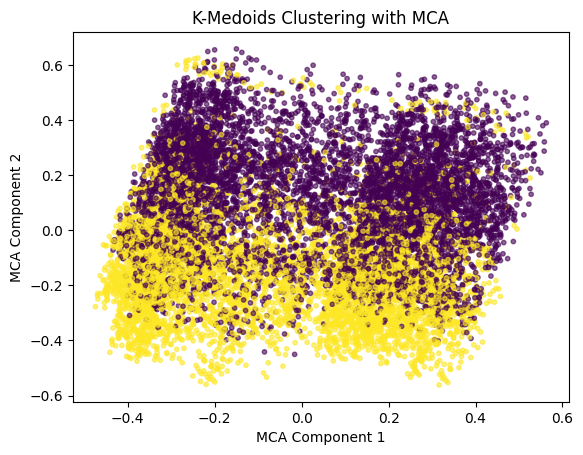

In [18]:
# K-Medoids clustering
kmedoids = KMedoids(n_clusters=2,metric = 'precomputed', random_state=0)
y_pred = kmedoids.fit_predict(D)
                                
plt.scatter(X_mca[0], X_mca[1], c=y_pred, cmap='viridis', alpha=0.6, s=10)
plt.title("K-Medoids Clustering with MCA")
plt.xlabel("MCA Component 1")
plt.ylabel("MCA Component 2")
plt.show()

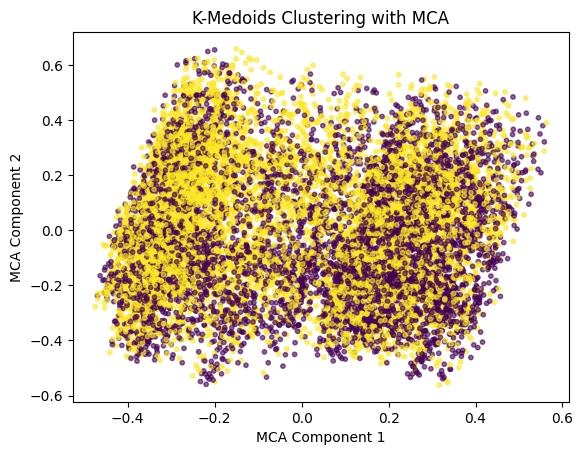

In [21]:
plt.scatter(X_mca[0], X_mca[1], c=y, cmap='viridis', alpha=0.6, s=10)
plt.title("K-Medoids Clustering with MCA")
plt.xlabel("MCA Component 1")
plt.ylabel("MCA Component 2")
plt.show()

In [23]:
y_pred.sum()/len(y_pred)

0.4455987311657415

In [20]:
coinciding_values/len(y_pred)

0.46582077716098336

In [18]:
df_test1 = df.copy()

In [19]:
df_test1['Cluster_Kmedoids'] = clusters

In [20]:
# Group by cluster label and then count the occurrences of each class in each cluster
class_distribution = df_test1.groupby('Cluster_Kmedoids')['Y'].value_counts()

print(class_distribution)

Cluster_Kmedoids  Y
0                 1     986
                  0     823
1                 1    1642
                  0    1466
2                 1    1286
                  0     868
3                 1     791
                  0     645
4                 1    1388
                  0     866
5                 1    1064
                  0     785
Name: count, dtype: int64


In [21]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute Euclidean distance matrix
D = squareform(pdist(X, metric='euclidean'))

# Range of k to evaluate
k_range = range(2, 5)  # Adjust according to your needs


for k in k_range:
    # Apply K-Medoids
    kmedoids = KMedoids(n_clusters=k,metric = 'precomputed', random_state=0)
    y_pred = kmedoids.fit_predict(D)
    
    silhouette_avg = silhouette_score(D ,y_pred, metric='precomputed')
    print(f"Gower Silhouette Score: {silhouette_avg}")
    # Calculate Dunn Index
    dunn_index_score = calculate_dunn_index(D, y_pred)
    print(f"Dunn Index: {dunn_index_score}")
    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X, y_pred) #davies_bouldin_index(X, y_pred)
    print(f"Davies-Bouldin Index: {db_index}")


    print(f"Contingency Matrix:\n{metrics.cluster.contingency_matrix(y, y_pred)}")
    print(f"Number of Clusters: {np.unique(y_pred).size}")
    print(f"Samples per Cluster: {np.unique(y_pred, return_counts=True)[1]}")
        
    ### Calculate composite score
    # Normalizing Silhouette Score (range [-1, 1] to [0, 1])
    normalized_silhouette = normalize_score(silhouette_avg, -1, 1)

    # Normalizing Dunn Index (Assuming a maximum reasonable value for normalization)
    # This maximum value is an assumption and should be adjusted based on domain knowledge
    max_reasonable_dunn = 0.5  # Example value, adjust based on your data
    davies_bouldin_index = 8
    normalized_dunn = normalize_score(dunn_index_score, 0, max_reasonable_dunn)

    # Normalizing Davies-Bouldin Index (using a logarithmic scale due to high values)
    # We add 1 to avoid log(0) in case of a DB index of 0
    normalized_davies_bouldin = 1 - np.log(1 + db_index) / np.log(1 + max(db_index, davies_bouldin_index))

    # Assuming equal weights for simplicity, but these can be adjusted
    weight_silhouette = 1/3
    weight_dunn = 1/3
    weight_davies_bouldin = 1/3

    # Calculating weighted average
    composite_score_normalized = (weight_silhouette * normalized_silhouette + 
                                    weight_dunn * normalized_dunn + 
                                    weight_davies_bouldin * normalized_davies_bouldin)
    print(f"Composite Score (Normalized): {composite_score_normalized}")

Gower Silhouette Score: 0.12253142522485645
Dunn Index: 0.07516460280028289
Davies-Bouldin Index: 2.5733442763296632
Contingency Matrix:
[[2854 2599]
 [4137 3020]]
Number of Clusters: 2
Samples per Cluster: [6991 5619]
Composite Score (Normalized): 0.37733307085390083
Gower Silhouette Score: 0.07265696760443122
Dunn Index: 0.10629880069054679
Davies-Bouldin Index: 3.519897999546153
Contingency Matrix:
[[2338 2192  923]
 [3245 2463 1449]]
Number of Clusters: 3
Samples per Cluster: [5583 4655 2372]
Composite Score (Normalized): 0.3541276534754157
Gower Silhouette Score: 0.03709970837036766
Dunn Index: 0.07516460280028289
Davies-Bouldin Index: 4.592319555290301
Contingency Matrix:
[[1434 2140  864 1015]
 [2000 2393 1341 1423]]
Number of Clusters: 4
Samples per Cluster: [3434 4533 2205 2438]
Composite Score (Normalized): 0.2951462735384577


In [16]:
kmedoids = KMedoids(n_clusters=6, random_state=0)
clusters = kmedoids.fit_predict(D)

### K-modes

In [26]:
D = squareform(pdist(X, metric='euclidean'))

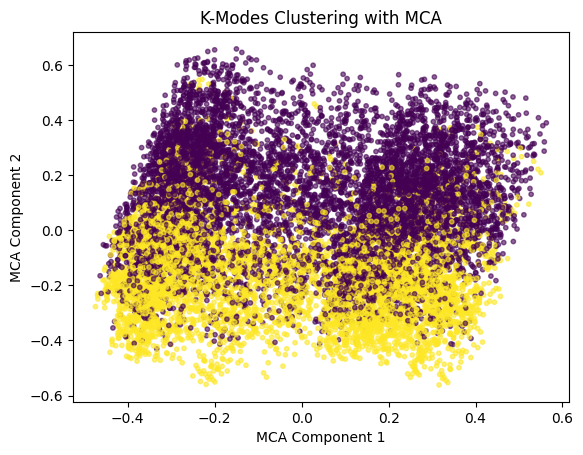

In [17]:
# K-Modes clustering
km = KModes(n_clusters=2, init='Huang', random_state=42)
y_pred = km.fit_predict(X)

plt.scatter(X_mca[0], X_mca[1], c=y_pred, cmap='viridis', alpha=0.6, s = 10)
plt.title("K-Modes Clustering with MCA")
plt.xlabel("MCA Component 1")
plt.ylabel("MCA Component 2")
plt.show()

In [22]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
D = squareform(pdist(X, metric='euclidean'))


# Range of k to evaluate
k_range = range(2, 5)  # Adjust according to your needs

# Store scores for each k
scores = []

for k in k_range:
    # Apply K-Medoids
    km = KModes(n_clusters=k, init='Huang', random_state=42)
    y_pred = km.fit_predict(X)
    
    silhouette_avg = silhouette_score(D ,y_pred, metric='precomputed')
    print(f"Gower Silhouette Score: {silhouette_avg}")
    # Calculate Dunn Index
    dunn_index_score = calculate_dunn_index(D, y_pred)
    print(f"Dunn Index: {dunn_index_score}")
    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X, y_pred) #davies_bouldin_index(X, y_pred)
    print(f"Davies-Bouldin Index: {db_index}")


    print(f"Contingency Matrix:\n{metrics.cluster.contingency_matrix(y, y_pred)}")
    print(f"Number of Clusters: {np.unique(y_pred).size}")
    print(f"Samples per Cluster: {np.unique(y_pred, return_counts=True)[1]}")
        
    ### Calculate composite score
    # Normalizing Silhouette Score (range [-1, 1] to [0, 1])
    normalized_silhouette = normalize_score(silhouette_avg, -1, 1)

    # Normalizing Dunn Index (Assuming a maximum reasonable value for normalization)
    # This maximum value is an assumption and should be adjusted based on domain knowledge
    max_reasonable_dunn = 0.5  # Example value, adjust based on your data
    davies_bouldin_index = 8
    normalized_dunn = normalize_score(dunn_index_score, 0, max_reasonable_dunn)

    # Normalizing Davies-Bouldin Index (using a logarithmic scale due to high values)
    # We add 1 to avoid log(0) in case of a DB index of 0
    normalized_davies_bouldin = 1 - np.log(1 + db_index) / np.log(1 + max(db_index, davies_bouldin_index))

    # Assuming equal weights for simplicity, but these can be adjusted
    weight_silhouette = 1/3
    weight_dunn = 1/3
    weight_davies_bouldin = 1/3

    # Calculating weighted average
    composite_score_normalized = (weight_silhouette * normalized_silhouette + 
                                    weight_dunn * normalized_dunn + 
                                    weight_davies_bouldin * normalized_davies_bouldin)
    print(f"Composite Score (Normalized): {composite_score_normalized}")

Gower Silhouette Score: 0.03582839169213371
Dunn Index: 0.07198157507486945
Davies-Bouldin Index: 5.24884840178849
Contingency Matrix:
[[3372 2081]
 [4014 3143]]
Number of Clusters: 2
Samples per Cluster: [7386 5224]
Composite Score (Normalized): 0.2759724816550711
Gower Silhouette Score: 0.015176979054428915
Dunn Index: 0.07198157507486945
Davies-Bouldin Index: 5.662514370181363
Contingency Matrix:
[[1455 2469 1529]
 [2660 2516 1981]]
Number of Clusters: 3
Samples per Cluster: [4115 4985 3510]
Composite Score (Normalized): 0.2628062275990954
Gower Silhouette Score: 0.0006411991065080866
Dunn Index: 0.07235746052924216
Davies-Bouldin Index: 5.3764331375682515
Contingency Matrix:
[[1909 1736 1145  663]
 [1680 2529 1955  993]]
Number of Clusters: 4
Samples per Cluster: [3589 4265 3100 1656]
Composite Score (Normalized): 0.2672922957717152


In [16]:
km = KModes(n_clusters=2, init='Huang', random_state=42)
clusters = km.fit_predict(X)

rand_index = adjusted_rand_score(y, clusters)
print(f'Rand Index: {rand_index}')

Rand Index: 0.001221186143976147


In [19]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Purity
def purity_score(y_true, y_pred):
    # compute confusion matrix
    confusion_matrix_ = confusion_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(confusion_matrix_, axis=0)) / np.sum(confusion_matrix_)

purity = purity_score(y, clusters)
print(f'Purity: {purity}')

# F1 Score
f1 = f1_score(y, clusters, average='macro')
print(f'F1 Score: {f1}')

Purity: 0.5675654242664552
F1 Score: 0.4604325667502479


### DBSCAN

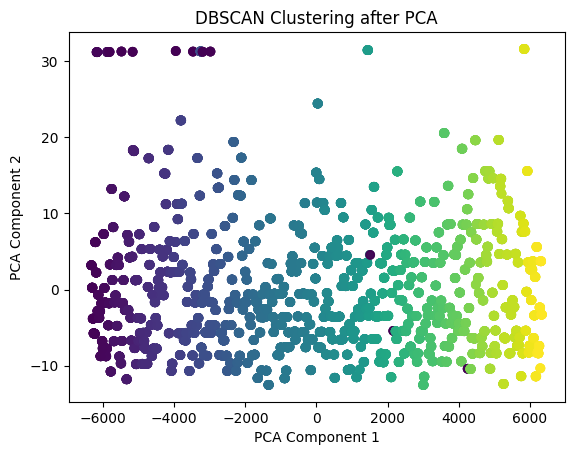

In [22]:
# DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=10)
clusters = dbscan.fit_predict(X)

# Plotting
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("DBSCAN Clustering after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

### Spectral clustering

In [23]:
# Spectral Clustering
spectral = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0)
clusters = spectral.fit_predict(X)

# Plotting
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Spectral Clustering after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

/Users/davidsousa/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 